In [6]:
%load_ext autoreload
%autoreload 2
import autoreload
%matplotlib inline

import warnings
from datetime import datetime
from urllib.parse import urlparse
from collections import Counter, OrderedDict
import timeit
from time import sleep
import os
import path
import io
import errno
import requests as r
import builtins
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request

import pickle
#import psycopg2
from numpy.linalg import svd, eig

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import spacy, re, nltk, gensim
import numpy as np
from numpy.linalg import svd, eig
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import itertools as it
import argparse

# Sklearn

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import load_iris, fetch_olivetti_faces
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

from pprint import pprint

# Plotting tools
#import pyLDAvis.sklearn
from dask.multiprocessing import get
import dask.dataframe as dd
import langdetect


# Always make it pretty.
# plt.style.use('default')
plt.style.use('ggplot')
%matplotlib inline


In [4]:
!python -m spacy download xx_ent_wiki_sm

    100% |████████████████████████████████| 32.6MB 5.8MB/s 
  Running setup.py install for xx-ent-wiki-sm ... done

    Linking successful
    /anaconda3/lib/python3.6/site-packages/xx_ent_wiki_sm -->
    /anaconda3/lib/python3.6/site-packages/spacy/data/xx_ent_wiki_sm

    You can now load the model via spacy.load('xx_ent_wiki_sm')



In [3]:
!python -m spacy download ru


    Compatibility error
    No compatible model found for 'ru' (spaCy v2.0.16).



In [894]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

In [65]:
from spacy.lang.ru import Russian
from os import listdir
from os.path import isfile, join
import codecs 


In [11]:
!pip install pymorphy2==0.8

    100% |████████████████████████████████| 51kB 1.6MB/s 
    100% |████████████████████████████████| 7.1MB 3.0MB/s 


In [915]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    if element == '\n':
        return False
    if element == ' ':
        return False
    return True

#def clean(element):
#    for e in element.replace('\n', ' '):
#        yield e.replace('\xa0',' ')
def clean(element):
    
# ст n чb  п şi de în a  d 
    return element.lower().replace('nr.','номер ').replace('статья',' ').replace('ст.',' ').replace('ч.','часть ')\
        .replace('_',' ').replace('|',' ').replace('/',' ').replace('\n', ' ').replace('\xa0',' ').replace('    ',' ').replace('  ',' ')\
        .replace('  ',' ').strip()

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)


def get_name(i):
    return 'dochtml/'+str(i//10000).zfill(3)+'/'+str(i//100).zfill(5)+'/'+str(i).zfill(3)+".txt"



def del_tr(el, tag):
    if el.parent == None:
        return
    if el.parent.name == tag:
        el.extract()
        return
    del_tr(el.parent, tag)

def del_by_text(soup, text):
    els = soup.findAll(text=re.compile(text))
    if (len(els) >0):
        del_tr(els[0], 'tr')

def del_by_tag(soup, tag):
    els = soup.findAll(tag)
    if (len(els) >0):
        del_tr(els[0], 'tr')

def read_text(fileName):
    html = open(fileName, 'rb').read()
    soup = BeautifulSoup(html, 'html.parser')
    extract(soup.findAll(attrs={"class" : "doc_sign1"}))
    extract(soup.findAll(name='script'))
    extract(soup.findAll(name='style'))
    del_by_text(soup, r'Внутренний номер')
    del_by_text(soup, r'Карточка документа')
    del_by_text(soup, r'Опубликован')
    del_by_tag(soup, 'img')
    del_by_tag(soup, 'strong')
    del_by_tag(soup, 'strong')

    texts = soup.findAll(text=True)
    return [clean(filtered) for filtered in filter(tag_visible, texts)]

In [918]:
def load_laws():
    ret = []
    for i in range(285022, 289815):
        p = get_name(i)
        if os.stat(p).st_size>70:
            try:
                ret.append((i, read_text(p)))
            except Exception as ex:
                pprint(p)
                pprint(ex)
    return ret

In [919]:
%%time
paths = load_laws()

CPU times: user 7min, sys: 2.85 s, total: 7min 2s
Wall time: 7min 6s


In [920]:
paths[1]

(285238,
 ['privind copiii luaţi la evidenţă pentru adopţie domiciliaţi',
  'pe teritoriul autorităţilor tutelare:',
  'cahul, telefon 239-2-37-19'])

In [921]:
df = pd.DataFrame(paths, columns=['id', 'text'])

In [922]:
def new_line_join(row):
    p = row
    return clean('\n'.join(row))

In [923]:
df['joined'] = df['text'].map(new_line_join)

In [924]:
js = df.iloc[4512]['joined']

In [925]:
df['is_clean'] = df['joined'] != js

In [926]:
df[df['is_clean'] == 0].count()

id          310
text        310
joined      310
is_clean    310
dtype: int64

In [929]:
df.head()

,id,text,joined,is_clean
0,285237,[rectificări],rectificări,True
1,285238,[privind copiii luaţi la evidenţă pentru adopţ...,privind copiii luaţi la evidenţă pentru adopţi...,True
2,285239,[по проекту конституционного закона о внесении...,по проекту конституционного закона о внесении ...,True
3,285240,[по проекту закона о внесении изменений и допо...,по проекту закона о внесении изменений и допол...,True
4,285241,"[заключение, по проекту конституционного закон...",заключение по проекту конституционного закона ...,True


In [931]:
df['len'] = df['joined'].map(len)

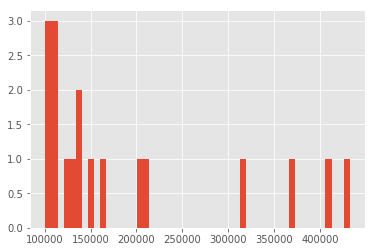

In [938]:
df[df['len']>100000]['len'].hist(bins=50)

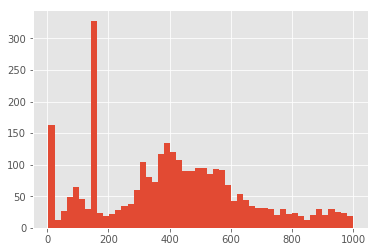

In [955]:
df[(df['len'] < 1000)]['len'].hist(bins=50)

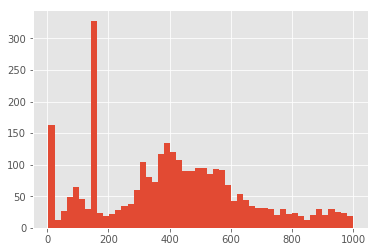

In [956]:
df[(df['len'] > 2) & (df['len'] < 1000)]['len'].hist(bins=50)

In [939]:
df.describe()

,id,len
count,4542.000000,4542.000000
mean,287522.303831,3243.205856
std,1315.969097,15216.377618
min,285237.000000,4.000000
25%,286385.250000,345.250000
50%,287524.500000,571.000000
75%,288660.750000,1597.500000
max,289814.000000,432606.000000


In [987]:
df[df['is_clean']].count()

id          4232
text        4232
joined      4232
is_clean    4232
len         4232
dtype: int64

In [66]:
import codecs
nlp = Russian()
nlp.
nlp.add_pipe(spacy.pipeline.SentenceSegmenter(nlp))

In [927]:
text = df.iloc[0]['joined']

In [928]:
text

'rectificări'

In [311]:
parsed_text = 

In [940]:
for s in nlp('ac212648/200 212648 : от 08.08.2003 "privind" şi de în a  d   |_ nr. copiii luaţi la evidenţă pentru adopţie domiciliaţi pe teritoriul autorităţilor tutelare cahul telefon 239 2 37 19 опубликовать 08.08.2003 в monitorul oficial nr').sents:
    for t in s:
        print(len(t),'.',t,t.lang_, t.is_alpha, t.is_digit, t.is_stop, t.is_ascii, t.is_punct, t.shape_)

12 . ac212648/200 ru False False False True False xxdddd/ddd
6 . 212648 ru False True False True False dddd
1 . : ru False False False True True :
2 . от ru True False True False False xx
10 . 08.08.2003 ru False False False True False dd.dd.dddd
1 . " ru False False False True True "
7 . privind ru True False False True False xxxx
1 . " ru False False False True True "
2 . şi ru True False False False False xx
2 . de ru True False False True False xx
2 . în ru True False False False False xx
1 . a ru True False False True False x
1 .   ru False False False True False  
1 . d ru True False False True False x
2 .    ru False False False True False   
1 . | ru False False False True False |
1 . _ ru False False False True True _
2 . nr ru True False False True False xx
1 . . ru False False False True True .
6 . copiii ru True False False True False xxxx
5 . luaţi ru True False False False False xxxx
2 . la ru True False False True False xx
8 . evidenţă ru True False False False False xxx

In [503]:
list(lemmatized_sentence_corpus(df[:3]))

['1mo152 внутренний номер varianta în limba de stat карточка документ республика молдова monitorul oficial поправка номер rectificări опубликовать monitorul oficial номер промульгирован',
 'ac212648 внутренний номер varianta în limba de stat карточка документ республика молдова другие эмитент информация номер privind copiii luaţi la evidenţă pentru adopţie domiciliaţi pe teritoriul autorităţilor tutelare cahul telefon опубликовать monitorul oficial номер статья № 225a',
 'acc1 внутренний номер varianta în limba de stat карточка документ республика молдова конституционный суд заключение номер проект конституционного закон внесение изменение дополнение некоторые статьи конституции опубликовать monitorul oficial номер статья № дата вступления силу имя республики молдова конституционный суд состав павел барбалат председатель николай кисеев судья докладчик михай которобай судья константин лозовану судья ион василати судья докладчик участие корины попа секретаря заседания иона море иона унгу

In [941]:
list(lemmatized_sentence_corpus(df[:2]))

['rectificări',
 'privind copiii luaţi evidenţă pentru adopţie domiciliaţi teritoriul autorităţilor tutelare cahul telefon 239']

In [771]:

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return len(token)<=2 or token.is_punct or token.is_space  or token.is_stop #or token.is_digit or token.shape_ == "dd.dd.dddd" or token.shape_ == "dd.dd.dd"

def line_review(df):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    for row in df[df['is_clean'] == 1]['text'].iteritems():
        for line in row[1]:
            yield line

def all_line_review(df):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    for row in df[df['is_clean'] == 1]['joined'].iteritems():
        yield row[1]
            
def lemmatized_sentence_corpus(df):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(all_line_review(df),
                                  batch_size=1000, n_threads=-1):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [957]:
unigram_sentences_filepath = os.path.join('unigram_sentences_all_2.txt')

In [958]:
%%time
with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for sentence in lemmatized_sentence_corpus(df):
        f.write(sentence + '\n')

CPU times: user 4min 17s, sys: 690 ms, total: 4min 18s
Wall time: 4min 19s


In [959]:
%%time
unigram_sentences = LineSentence(unigram_sentences_filepath)
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(' '.join(unigram_sentence))
    print('')

перечисленные конституционные принципы являться составной частью пропагандистка риторики

данные политические правовые ценности детализировать собрать система конституционных гарантия обеспечивающих основы государственности несоблюдение влечь соответствие конституции ответственность президента страны перед нация

учитывать вышеизложенное считаю проблема поднять обращение президента республики молдова предмет рассмотрения конституционном суд действующая конституция допускать пересмотр высшего закон путем проведения референдум

народ республики молдова согласно часть конституции осуществлять национальный суверенитет непосредственно путем принятия новой конституции текст иметь ничего общего текст ныне действующей конституции

судья конституционного суда георге сусаренко м.о

1999

124 125

проект закон дополнение 135 изменение 136 конституции республики молдова имя республики молдова конституционный суд состав виктор пушкаша председатель судья докладчик алина янученко судья мирча юг судья

In [960]:
bigram_model_filepath = os.path.join( 'bigram_model_all')

In [961]:
bigram_model = Phrases(unigram_sentences)
bigram_model.save(bigram_model_filepath)
# load the finished model from disk
bigram_model = Phrases.load(bigram_model_filepath)

In [962]:
bigram_sentences_filepath = os.path.join('bigram_sentences_all.txt')

with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for unigram_sentence in unigram_sentences:
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence + '\n')
bigram_sentences = LineSentence(bigram_sentences_filepath)
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(' '.join(bigram_sentence))
    print('')

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


перечисленные конституционные_принципы являться_составной частью пропагандистка риторики

данные политические правовые ценности детализировать собрать система конституционных гарантия обеспечивающих основы государственности несоблюдение влечь соответствие конституции ответственность президента страны перед нация

учитывать_вышеизложенное считаю проблема поднять обращение президента_республики молдова предмет рассмотрения конституционном_суд действующая конституция допускать пересмотр_высшего закон путем проведения_референдум

народ республики_молдова согласно часть_конституции осуществлять национальный_суверенитет непосредственно путем_принятия новой конституции текст иметь ничего общего текст ныне действующей конституции

судья конституционного_суда георге_сусаренко м.о

1999

124_125

проект закон дополнение 135 изменение 136 конституции_республики молдова имя республики_молдова конституционный_суд состав_виктор пушкаша_председатель судья_докладчик алина_янученко судья_мирча юг_судья

In [963]:
%%time
trigram_model_filepath = os.path.join('trigram_model_all')
trigram_model = Phrases(bigram_sentences)
trigram_model.save(trigram_model_filepath)
# load the finished model from disk
trigram_model = Phrases.load(trigram_model_filepath)
trigram_sentences_filepath = os.path.join('trigram_sentences_all.txt')

CPU times: user 3.99 s, sys: 224 ms, total: 4.22 s
Wall time: 4.23 s


In [964]:
%%time
trigram_reviews_filepath = os.path.join('trigram_transformed_reviews_all.txt')
with codecs.open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:
    for parsed_review in nlp.pipe(all_line_review(df),
                                  batch_size=1000, n_threads=-1):
        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review
                          if not punct_space(token)]
        # apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]
        # remove any remaining stopwords
        trigram_review = [term for term in trigram_review
                          if term not in stop_words]
        # write the transformed review as a line in the new file
        trigram_review = u' '.join(trigram_review)
        f.write(trigram_review + '\n')

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 4min 30s, sys: 657 ms, total: 4min 31s
Wall time: 4min 32s


In [965]:
%%time
trigram_dictionary_filepath = os.path.join('trigram_dict_all.dict')
trigram_reviews = LineSentence(trigram_reviews_filepath)

# learn the dictionary by iterating over all of the reviews
trigram_dictionary = Dictionary(trigram_reviews)

# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
trigram_dictionary.compactify()

trigram_dictionary.save(trigram_dictionary_filepath)

CPU times: user 1.11 s, sys: 35.2 ms, total: 1.15 s
Wall time: 1.15 s


In [966]:
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

In [967]:
%%time
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for bigram_sentence in bigram_sentences:
        trigram_sentence = u' '.join(trigram_model[bigram_sentence])
        f.write(trigram_sentence + '\n')

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 4.44 s, sys: 82.6 ms, total: 4.52 s
Wall time: 4.56 s


In [968]:
trigram_sentences = LineSentence(trigram_sentences_filepath)
for trigram_sentence in it.islice(trigram_sentences, 280, 290):
    print(' '.join(trigram_sentence))
    print('')

условие конституции закреплять требование равновесие власть требование практически осуществимое суд_отмечать пересмотр 136 конституции нарушать_принцип разделения_взаимодействия государственных власть предусмотренный конституция

конституции предполагать возможность обязанность ветвь_власти взаимодействовать предел прерогатива исполнения государственной_власти

учитывать независимость судьи любой публичной_власти требование предусмотренное 137 конституции назначение судьи_президент_республики_молдова являться вмешательство_деятельность законодательной судебной_власть

следовательно проект_закон представленный конституционный_суд дачи_заключения вписываться пределы_пересмотр_конституции предусмотренные_142 конституции соответствовать_требование суверенном_независимом едином характер_государства

сути положения_проект_конституционного закон ущемлять основные_права_свободы_граждан нарушать единство конституционной_материи

исходить_изложенного_учитывать соответствие_141_часть конституции_

In [95]:
!pip install stop-words

  Running setup.py bdist_wheel for stop-words ... done
  Stored in directory: /Users/tbd/Library/Caches/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [393]:
from stop_words import get_stop_words

stop_words = get_stop_words('ru')

In [394]:
stop_words[:10]

['а', 'в', 'г', 'е', 'ж', 'и', 'к', 'м', 'о', 'с']

In [784]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [969]:
trigram_bow_filepath = os.path.join('trigram_bow_corpus_all.mm')

In [970]:
MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_reviews_filepath))

# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

In [971]:
trigram_bow_corpus.length

In [972]:
lda_model_filepath = os.path.join('lda_model_all')

In [973]:
%%time
# workers => sets the parallelism, and should be
# set to your number of physical cores minus one
lda = LdaMulticore(trigram_bow_corpus,
                   num_topics=100,
                   id2word=trigram_dictionary,
                   workers=6,alpha='asymmetric')

lda.save(lda_model_filepath)

# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 4.86 s, sys: 1.02 s, total: 5.88 s
Wall time: 5.31 s


In [896]:
def get_sample_review(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    return list(df['joined'][:review_number])

In [1048]:
def lda_description(review_text, min_topic_freq=0.005, exp=True):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    if exp:
        print(review_text)
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in stop_words]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]
    # sort with the most highly related topics first
    review_lda = sorted(review_lda, key=lambda x: -x[1])
    ret = []
    for topic_number, freq in review_lda:
        if freq < min_topic_freq:
            break
        ret.append(topic_number)
        if exp:
            # print the most highly related topic names and frequencies
            print('{:25} {}'.format(topic_number,
                                    round(freq, 3)))
            explore_topic(topic_number=topic_number, topn=3)
    return ret

In [742]:
sample_review = get_sample_review(10)

In [1042]:
lda_description(df['joined'][2075])

распоряжение в целях изучения проблем, связанных с обменом собственности, приобретением участков и зданий для иностранных дипломатических представительств в республике молдова и республики молдова за рубежом, образовать комиссию в следующем составе: осталеп валериу - заместитель министра иностранных дел и европейской интеграции (председатель комиссии) члены комиссии: виеру михай - заместитель руководителя аппарата правительства бынзару валериан - начальник управления финансов национальной экономики и капитальных вложений министерства финансов вылку-бажурян - консультант управления разработки наталья нормативных актов министерства юстиции козловски корнелия - генеральный директор агентства приватизации при министерстве экономики и торговли фуртунэ михай - заместитель примара муниципия кишинэу логош константин - начальник управления менеджмента и логистики министерства иностранных дел и европейской интеграции суручану геоpге - начальник упpавления по обслуживанию дипломатического коpпуса

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [1029]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print('term             frequency')

    for term, frequency in lda.show_topic(topic_number, topn=topn):
        print('{:40} {:.3f}'.format(term, round(frequency, 3)).replace(' ',' '))

def save_topics(topn=25):
    df = pd.DataFrame(data=list(range(topn)))
    for topic_number in range(140):
        df['topic_number_'+str(topic_number)] = [term for term, frequency in lda.show_topic(topic_number, topn=topn)]
    df.to_csv()
    return df

In [1031]:
save_topics(25).to_csv('topics.csv', )

In [1049]:
def topic_dist(df):
    c = Counter()
    for doc in df['joined']:
        c.update(lda_description(doc, exp=False))
    return c

In [1050]:
%%time
t_dist = topic_dist(df)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 9min 58s, sys: 1min, total: 10min 59s
Wall time: 4min 46s


In [1058]:
arr = []
for k,v in t_dist.items():
    arr= arr + ([k]*v)

(array([3267., 2506., 1771., 1387.,  873., 1312., 1377., 1277., 1279.,
         715.,   93.,  119.,  161.,   71.,   59.,  100.,  170.,   83.,
          48.,   96.,   84.,   89.,  139.,   83.,  101.,   75.,   81.,
         157.,   99.,   90.,  125.,   49.,   68.,  102.,  106.,  171.,
         110.,   91.,  165.,   84.,   46.,  133.,   83.,   84.,   80.,
          35.,   54.,  138.,   70.,  105.]),
 array([  0.  ,   2.78,   5.56,   8.34,  11.12,  13.9 ,  16.68,  19.46,
         22.24,  25.02,  27.8 ,  30.58,  33.36,  36.14,  38.92,  41.7 ,
         44.48,  47.26,  50.04,  52.82,  55.6 ,  58.38,  61.16,  63.94,
         66.72,  69.5 ,  72.28,  75.06,  77.84,  80.62,  83.4 ,  86.18,
         88.96,  91.74,  94.52,  97.3 , 100.08, 102.86, 105.64, 108.42,
        111.2 , 113.98, 116.76, 119.54, 122.32, 125.1 , 127.88, 130.66,
        133.44, 136.22, 139.  ]),
 <a list of 50 Patch objects>)

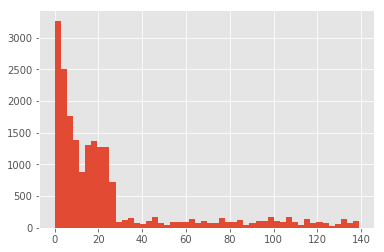

In [1060]:
plt.hist(arr, bins=50)

In [1055]:
[i for i in t_dist]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 29,
 60,
 55,
 27,
 62,
 132,
 97,
 137,
 36,
 91,
 105,
 126,
 47,
 40,
 33,
 53,
 138,
 100,
 120,
 86,
 77,
 101,
 81,
 46,
 39,
 64,
 34,
 114,
 117,
 115,
 108,
 113,
 48,
 68,
 32,
 65,
 122,
 109,
 124,
 102,
 128,
 89,
 58,
 116,
 78,
 37,
 42,
 84,
 67,
 35,
 70,
 80,
 43,
 59,
 133,
 38,
 41,
 118,
 107,
 44,
 49,
 88,
 96,
 85,
 130,
 56,
 110,
 79,
 139,
 71,
 136,
 98,
 93,
 87,
 90,
 52,
 51,
 104,
 57,
 74,
 66,
 72,
 54,
 135,
 131,
 121,
 83,
 69,
 76,
 94,
 31,
 119,
 125,
 134,
 73,
 61,
 45,
 75,
 92,
 103,
 30,
 50,
 112,
 129,
 95,
 123,
 111,
 63,
 99,
 28,
 127,
 106,
 82]

In [712]:
lda.id2word[1]

'молдова'

In [1022]:
lda.get_topics().shape

(140, 9261)

In [713]:
lda.get_term_topics(1)

[(1, 0.010086156), (27, 0.01652864), (28, 0.014120474)]

In [1061]:
explore_topic(topic_number=1)

term             frequency
dispoziţie                               0.011
основание_части_статьи_конституции       0.010
республики_молдова_президент_республики  0.009
молдова_постановлять_промульгировать_закон 0.008
президент_республики_молдова_постановлять 0.006
республики_молдова                       0.005
случай                                   0.004
молдова                                  0.004
закон                                    0.004
пункт                                    0.004
промульгации_закон_внесение_изменение    0.004
privire                                  0.003
президент_республики_молдова             0.003
соответствие                             0.003
промульгации_закон                       0.003
приложение                               0.003
президент_республики_молдова_петру       0.003
деятельности                             0.003
privind                                  0.002
основание                                0.002
слова                         

In [1064]:
explore_topic(topic_number=1)

term             frequency
dispoziţie                               0.011
основание_части_статьи_конституции       0.010
республики_молдова_президент_республики  0.009
молдова_постановлять_промульгировать_закон 0.008
президент_республики_молдова_постановлять 0.006
республики_молдова                       0.005
случай                                   0.004
молдова                                  0.004
закон                                    0.004
пункт                                    0.004
промульгации_закон_внесение_изменение    0.004
privire                                  0.003
президент_республики_молдова             0.003
соответствие                             0.003
промульгации_закон                       0.003
приложение                               0.003
президент_республики_молдова_петру       0.003
деятельности                             0.003
privind                                  0.002
основание                                0.002
слова                         

In [1066]:
explore_topic(topic_number=2)

term             frequency
республики_молдова                       0.005
закон                                    0.004
президент_республики_молдова_постановлять 0.004
соответствие                             0.003
случай                                   0.003
приложение                               0.003
основание_части_статьи_конституции       0.003
республики_молдова_президент_республики  0.003
указ                                     0.003
пункт                                    0.003
деятельности                             0.003
молдова                                  0.003
условие                                  0.003
орган                                    0.002
согласно                                 0.002
лицензии                                 0.002
являться                                 0.002
положения                                0.002
работа                                   0.002
основание                                0.002
связи                           

In [1067]:
explore_topic(topic_number=3)

term             frequency
республики_молдова                       0.011
президент_республики_молдова_постановлять 0.005
молдова                                  0.005
класс                                    0.005
пункт                                    0.004
основание_части_статьи_конституции       0.004
основание                                0.004
российской_федерации                     0.003
присвоения_классных_чинов_государственным 0.003
служащим_1263-xiii_июль_1997             0.003
республики_молдова_президент_республики  0.003
закон_положение_порядок                  0.003
закон_государственной_службе             0.003
статьи_конституции_республики_молдова    0.002
случай                                   0.002
распоряжение_соответствие                0.002
определение                              0.002
443-xiii_мая_1995                        0.002
документ                                 0.002
iii_класс                                0.002
соответствие                   

In [979]:
explore_topic(topic_number=8)

term             frequency
республики_молдова                       0.009
парламент                                0.008
закон                                    0.007
случай                                   0.005
молдова                                  0.005
основание_части_статьи_конституции       0.004
республики_молдова_президент_республики  0.004
положение                                0.004
президент_республики_молдова             0.004
согласно                                 0.004
pentru                                   0.004
молдова_постановлять_промульгировать_закон 0.004
конституционный_суд                      0.004
пункт                                    0.003
вопрос                                   0.003
основание                                0.003
соответствие                             0.003
право                                    0.003
являться                                 0.003
президент_республики_молдова_постановлять 0.003
конституции_республики_молдова

In [980]:
explore_topic(topic_number=4)

term             frequency
республики_молдова_президент_республики  0.024
основание_части_статьи_конституции       0.024
молдова_постановлять_промульгировать_закон 0.021
промульгации_закон_внесение_изменение    0.010
республики_молдова                       0.008
промульгации_закон                       0.005
президент_республики_молдова_постановлять 0.004
президент_республики_молдова             0.004
дополнение_закон                         0.004
изменение_дополнение_закон               0.004
молдова                                  0.004
организации                              0.004
изменение                                0.003
президент_республики_молдова_петру       0.003
закон                                    0.003
случай                                   0.003
акты                                     0.002
владимир_воронин_кишинэу_декабрь         0.002
правительство                            0.002
2002                                     0.002
дополнение_некоторые_законодат

In [981]:
explore_topic(topic_number=5)

term             frequency
республики_молдова                       0.010
молдова                                  0.009
президент_республики_молдова_постановлять 0.006
пункт                                    0.005
кишинэу                                  0.004
случай                                   0.003
президент_республики_молдова_петру       0.003
документ                                 0.003
настоящий_указ_вступать_силу             0.003
указ_президента_республики_молдова       0.003
основание_части_статьи_конституции       0.003
банк                                     0.003
являться                                 0.003
республики_молдова_президент_республики  0.003
указ                                     0.003
судья                                    0.003
день_подписания                          0.002
президент_республики_молдова             0.002
банка                                    0.002
связи                                    0.002
статьи_конституции_республики_мо

In [982]:
explore_topic(topic_number=6)

term             frequency
республики_молдова                       0.009
закон                                    0.006
ценных_бумага                            0.005
основание                                0.005
президент_республики_молдова_постановлять 0.005
случай                                   0.004
республики_молдова_президент_республики  0.004
кишинэу                                  0.004
основание_части_статьи_конституции       0.004
молдова_постановлять_промульгировать_закон 0.004
часть                                    0.004
парламент                                0.003
статьи_конституции_республики_молдова    0.003
промульгации_закон_внесение_изменение    0.003
являться                                 0.003
мун                                      0.003
промульгировать_закон                    0.003
вопрос                                   0.003
порядок                                  0.003
молдова                                  0.003
согласно                      

In [983]:
explore_topic(topic_number=138)

term             frequency
случай                                   0.008
работа                                   0.007
работы                                   0.005
февраль_2003                             0.005
закон                                    0.004
заявление                                0.004
порядок                                  0.004
комиссии                                 0.003
приложение                               0.003
республики_молдова                       0.003
согласно                                 0.003
орган                                    0.003
акт                                      0.003
срок                                     0.003
либо                                     0.003
контроль                                 0.003
работник                                 0.002
часть                                    0.002
являться                                 0.002
деятельности                             0.002
судебный_инстанция               

In [984]:
from gensim.models import Word2Vec

trigram_sentences = LineSentence(trigram_sentences_filepath)
word2vec_filepath = os.path.join( 'word2vec_model_all')

In [988]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the word2vec model yourself.
#if 0 == 1:

# initiate the model and perform the first epoch of training
food2vec = Word2Vec(trigram_sentences, size=100, window=5,min_count=20, sg=1, workers=4)

food2vec.save(word2vec_filepath)

# perform another 11 epochs of training
food2vec.train(trigram_sentences, total_examples=4232, epochs=11)
food2vec.save(word2vec_filepath)

# load the finished model from disk
food2vec = Word2Vec.load(word2vec_filepath)
food2vec.init_sims()

print( u'{} training epochs so far.'.format(food2vec.train_count))

2 training epochs so far.
CPU times: user 41.6 s, sys: 632 ms, total: 42.3 s
Wall time: 13.2 s


In [989]:
%%time
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in food2vec.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda x: -x[2]) #(term, index, count)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(food2vec.wv.syn0norm[term_indices, :],
                            index=ordered_terms)


CPU times: user 14.2 ms, sys: 1.58 ms, total: 15.8 ms
Wall time: 14.4 ms


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  


In [1272]:

def get_related_termss(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """
    for word, similarity in food2vec.wv.most_similar(positive=[t.lower() for t in token], topn=topn):

        print(u'{:20} {}'.format(word, round(similarity, 3)))
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """
    
    for word, similarity in food2vec.wv.most_similar(positive=[token.lower()], topn=topn):

        print(u'{:20} {}'.format(word, round(similarity, 3)))

In [1273]:
get_related_terms(u'сила')

среды                0.909
повышение_квалификации 0.905
хозяйственной_деятельности 0.902
занятия              0.899
эффективное          0.897
задачи               0.897
внимания             0.894
министерства_департаменты 0.894
задание              0.894
деятельности_область_исследование_инновация 0.892


In [1274]:
get_related_terms(u'бухгалтер')

главный              0.913
главный_бухгалтер    0.876
руководитель         0.876
главного_бухгалтера  0.874
заверяться_печать    0.874
подразделения        0.872
фирмы                0.869
инспектор            0.868
электронные          0.859
телефон              0.854


In [1275]:
get_related_terms(u'год', topn=13)

часы                 0.694
протяжение           0.687
окончание            0.683
предыдущих           0.672
конкретный           0.649
рабочего_времени     0.648
начинаться           0.648
составления          0.647
февраль              0.645
отбывания_наказания  0.644
раз                  0.643
январь               0.642
рабочего_день        0.639


In [1276]:
get_related_terms(u'страна', topn=13)

представительства    0.777
других_государство   0.769
юридические_лица     0.76
физические_лица      0.75
иным                 0.75
иностранные          0.744
статус               0.742
пользоваться         0.738
иностранный          0.736
объединения          0.734
созданные            0.73
общественных_организация 0.726
других_страна        0.724


In [1224]:
def word_algebra(add=[], subtract=[], topn=5):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = food2vec.wv.most_similar(positive=add, negative=subtract, topn=topn)

    pr = ''
    if len(add) >0:
        pr += ' + '.join(add)

    if (len(add) >0) & (len(subtract)>0):
        pr += ' - '

    if len(subtract)>0:
        pr += ' - '.join(subtract)

    if topn == 1:
        print(pr, '=', answers[0][0])
    else:
        print(pr, '=',', '.join([term.replace('_', ' ') for term, similarity in answers]))

In [1226]:
word_algebra(subtract=[u'внимание'], topn=3)

внимание = строке порядок указанном, сын, проживает республике молдова


In [1256]:
word_algebra(add=[u'бухгалтер', u'инспектор'])#главный
word_algebra(add=[u'бухгалтер'], subtract=['главный'])#следующего
word_algebra(add=[u'бухгалтер', u'печать'])#заверяться_печать
word_algebra(add=[u'город', u'печать'])#таможенного
word_algebra(add=[u'город', u'суд'])#районный
word_algebra(add=[u'город'], subtract=['бухгалтер'])#продукции
word_algebra(add=[u'город','суд'])#выполненных
word_algebra(add=[u'уезд','суд'])#город

бухгалтер + инспектор = главный, фирмы, секретарь совет, заверяться печать, ко-
бухгалтер - главный = период поддержания, отчетного период, снятия, последующих, остаток
бухгалтер + печать = уполномоченного лица, подпись руководителя, электронные, заверяться печать, фамилия имя отчество
город + печать = фамилия имя отчество, местонахождения, бухгалтер, налоговый, расположения
город + суд = районный, пост, городов, фискальные коды, занимаемой должности
город - бухгалтер = населенных пункт, единицы, статус, 123, акцизы
город + суд = районный, пост, городов, фискальные коды, занимаемой должности
уезд + суд = городов, районный, занимаемой должности, примэрии, обжаловано


In [1266]:
word_algebra(add=[u'женщины', u'отец'])

женщины + отец = возраст лет, органы опеки попечительства, матери, болезнь, привлекаться


In [1230]:
word_algebra(add=[u'валюта', u'суд']) #банкноты
word_algebra(add=[u'валюта', u'язык']) #казначейский_счет_доход
word_algebra(add=[u'валюта'], subtract=[u'бухгалтер'])#налогового_кодекс
word_algebra(add=[u'валюта', u'акциз'])#ндс
word_algebra(add=[u'валюта', u'акциз', u'импорт'])#таможенных_платёж
word_algebra(add=[u'валюта', u'чек'])#получатель

валюта + суд = государственной пошлины, размер алименты, взыскиваться, опека попечительство, изъять
валюта + язык = казначейский счет доход, молдавских, государственный налоговый регистр, пример, таможенных платёж
валюта - бухгалтер = иностранный валюта, республика молдова, налогового кодекс, акциз, предмет лизинг
валюта + акциз = ндс, таможенных пошлина, казначейский счет доход, таможенных платёж, комиссионные
валюта + акциз + импорт = таможенных платёж, таможенных пошлина, ндс, казначейский счет доход, импорт товар услуга
валюта + чек = получатель, подразделение государственного казначейства, код валюты, осуществление расчёт, акт приемки


In [1268]:
get_related_terms(u'женщины')

исполнение_обязанность 0.965
памятник             0.956
опекунов_попечителей 0.952
районные             0.951
воспитания           0.949
примэрия             0.949
семье                0.944
привлекаться         0.942
опеки_попечительства 0.942
гражданского         0.94


In [1232]:
get_related_terms(u'лей')

население_лей        0.778
тыс.лей              0.737
2,5                  0.733
тыс                  0.721
ная                  0.692
средний              0.692
млн                  0.691
дилера               0.687
государственным_облигация 0.68
снг                  0.678


In [1233]:
get_related_terms(u'сша')

снг                  0.87
румыния              0.866
население_лей        0.86
400                  0.859
россия               0.857
usd                  0.854
700                  0.845
840                  0.827
беларусь             0.827
2,5                  0.826


In [1234]:
get_related_terms(u'пенсионер')
word_algebra(add=[u'пенсионер', u'лей'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'пенсионер'], subtract=[u'лей'])

социальному_страхование 0.966
пенсионеров          0.96
уход_ребёнок         0.957
инвалидности         0.953
надбавка             0.95
особо                0.946
пособие              0.945
заработный_плату     0.944
пособия              0.937
заработный_плата     0.934
пенсионер + лей = размер менее, надбавка, тонна, смена, \xf5
пенсионер - лей = свободы, преступление, последствие, наказания, прав свобода


In [1279]:
get_related_terms(u'РАСПОРЯЖЕНИЕ')

вышеуказанного       0.753
открытие             0.751
чеков_иностранной_валюте 0.751
наличный_иностранный_валюта 0.744
касса                0.736
изъять               0.734
взыскание            0.732
оставаться           0.727
налоговых_обязательство 0.726
пополнения           0.725


In [1236]:
get_related_terms(u'президент', )
word_algebra(add=[u'студент', u'валюта'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'пенсионер'], subtract=[u'лей'])

премьер_министр      0.887
примара              0.877
избран               0.871
примар               0.864
избираться           0.858
кандидатура          0.853
осуществлять_полномочия 0.85
избрания             0.849
премьер_министра     0.848
избрать              0.847
студент + валюта = дорога, взаимозачет, таможенных платёж, валютной выручки, проезд
пенсионер - лей = свободы, преступление, последствие, наказания, прав свобода


In [1237]:
# get_related_termss([u'закон',u'народ'], topn=40)
word_algebra(add=[u'закон'], subtract=[u'народ'])

закон - народ = monitorul oficial republicii moldova, постановление правительства республики молдова, регламент, утрачивать силу, инструкции


In [1238]:
word_algebra(add=[u'народ'], subtract=[u'закон'])
word_algebra(add=[u'дела', u'закон'], topn=5)
word_algebra(add=[u'закон', u'народ'])
word_algebra(add=[u'народ', u'закон'])

народ - закон = дела, семьи, гум, социальный, интерес
дела + закон = инстанция, орган публичной власти, силы, сути, недопустимо
закон + народ = власть, суверенитет, подразумевать, ущемлять, равенство
народ + закон = власть, суверенитет, подразумевать, ущемлять, равенство


In [1239]:
word_algebra(add=[u'товар', u'закон'], topn=5)
word_algebra(add=[u'товар'], subtract=[u'закон'], topn=5)

товар + закон = перемещения, отношений между, предмет лизинг, платеж, обязательное
товар - закон = импортера, ввоз, канал, склад, груз


In [1241]:
word_algebra(add=[u'молдова', u'сша'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'молдова', u'россия'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'молдова', u'лей'])# , subtract=[u'обжалованы'])

word_algebra(add=[u'молдова'], subtract=[u'румыния'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'молдова'], subtract=[u'румыния'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'молдова'], subtract=[u'россия'])# , subtract=[u'обжалованы'])

молдова + сша = снг, румыния, беларусь, украина, россия
молдова + россия = румыния, беларусь, снг, украина, население лей
молдова + лей = население лей, снг, румыния, 2,5, украина
молдова - румыния = национальный банк молдова, рассмотрение, разрешения, дело, вместе
молдова - румыния = национальный банк молдова, рассмотрение, разрешения, дело, вместе
молдова - россия = национальный банк молдова, представления, разрешения, вместе, рассмотрение


In [1242]:
word_algebra(add=[u'штраф'], subtract=[u'наказание'])
word_algebra(add=[u'штраф', u'наказание'])

штраф - наказание = министерство финансы, государственный бюджет, текущие счета, деньга, выкуп гцб
штраф + наказание = осуждение, материального ущерб, наказания, лишение свободы, лишения свободы


In [1244]:
word_algebra(add=[u'преступление'], subtract=[ u'экспертиза'])

преступление - экспертиза = гражданин республики молдова, совершенное, неприкосновенность, гражданства, наказываться лишение свободы срок


In [1245]:
word_algebra(add=[u'гражданин_республики_молдова'], subtract=[ u'закон'])

гражданин_республики_молдова - закон = пользоваться, физические лица, без гражданства, украина, иностранных граждан лиц, международные, семьи, защита, иностранные гражданин лица без, гражданства


In [1247]:
word_algebra(add=[u'анализ',  u'документ'])
word_algebra(add=[u'анализ'], subtract=[u'документ'])
word_algebra(add=[u'документ'], subtract=[u'анализ'])

анализ + документ = хозяйствующих субъектов, основываться, обоснование, экспертизы, рабочих место
анализ - документ = оценка, политики, национальной экономики, энергетики, исследование
документ - анализ = право, подписи, лица, оттиск печати, надписи


In [1248]:
word_algebra(add=[u'молдова'], subtract=[u'сша'])# , subtract=[u'обжалованы'])

молдова - сша = pешение, президента республики молдова, рассмотрения, кодекс конституционной юрисдикции, выборов


In [1250]:
word_algebra(add=[u'железной_дороге', u'валюта'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'город'], subtract=[u'язык'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'расторжение_брак'], subtract=[u'обжалованы'])# , subtract=[u'обжалованы'])

железной_дороге + валюта = багаж, валютной выручки, таможенных платёж, пример, контейнер
город - язык = кишинэу, состав, уезд, акб, бэлць
расторжение_брак - обжалованы = железный дорога, ремонт, груз, дома, лаборатория


In [1254]:
word_algebra(add=[u'семья', u'лей'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'семья'], subtract=[u'лей'])# , subtract=[u'обжалованы'])
word_algebra(add=[u'город'], subtract=[u'язык'])# , subtract=[u'обжалованы'])

семья + лей = двор, школа, сельскохозяйственной, жильё, учащимся
семья - лей = воспитание, последствие, общественного, охраны, несовершеннолетних
город - язык = кишинэу, состав, уезд, акб, бэлць


In [1119]:
%%time

from sklearn.manifold import TSNE

tsne_input = word_vectors.drop(stop_words, errors=u'ignore')
tsne_input = tsne_input.head(10000)
tsne_filepath = os.path.join(u'tsne_model')
tsne_vectors_filepath = os.path.join(u'tsne_vectors.npy')

CPU times: user 4.72 ms, sys: 35.4 ms, total: 40.1 ms
Wall time: 120 ms


In [1120]:
%%time

if 1 == 1:    
    tsne = TSNE(perplexity=100)
    tsne_vectors = tsne.fit_transform(tsne_input.values)
    #with open(tsne_filepath, 'w') as f:
    #    pickle.dump(tsne, f)

    pd.np.save(tsne_vectors_filepath, tsne_vectors)

CPU times: user 4min 16s, sys: 18.6 s, total: 4min 35s
Wall time: 4min 35s


In [1121]:
tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord'])

tsne_vectors[u'word'] = tsne_vectors.index

In [1122]:
tsne_vectors.to_pickle('bokeh_100')

In [843]:
pd.np.save('tsne_values', tsne_input.values)
pd.DataFrame.to_pickle( tsne_input, 'tsne_input')

TypeError: write() argument must be str, not bytes

In [849]:
tsne_vectors

array([[ 53.353573 , -15.902899 ],
       [-31.080439 , -22.348173 ],
       [ 34.66714  , -42.139538 ],
       ...,
       [ 17.969688 ,  -4.7765765],
       [-27.796118 , -53.758804 ],
       [-13.999111 , -14.578036 ]], dtype=float32)

In [1123]:
pd.DataFrame.to_pickle(tsne_vectors, 'tsne_df_100')

In [638]:
pd.np.save(tsne_vectors_filepath, tsne_vectors)

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(pd.DataFrame(tsne_vectors, columns=['x', 'y']))

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);